In [5]:
from datetime import datetime

import matplotlib.pyplot as plt
from metpy.plots import SkewT
from metpy.units import pandas_dataframe_to_unit_arrays, units
import numpy as np

import metpy.calc as mpcalc
from metpy.cbook import get_test_data

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd

In [6]:
col_names = ['pressure', 'height', 'temperature', 'dewpoint', 'direction', 'speed']

df = pd.read_fwf(get_test_data('nov11_sounding.txt', as_file_obj=False),
                 skiprows=5, usecols=[0, 1, 2, 3, 6, 7], names=col_names)

# Drop any rows with all NaN values for T, Td, winds
df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed'
                       ), how='all').reset_index(drop=True)

##########################################################################

# We will pull the data out of the example dataset into individual variables and
# assign units.

p = df['pressure'].values * units.hPa
T = df['temperature'].values * units.degC
Td = df['dewpoint'].values * units.degC
wind_speed = df['speed'].values * units.knots
wind_dir = df['direction'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

923.1157642313738 hectopascal 15.595751336163403 degree_Celsius


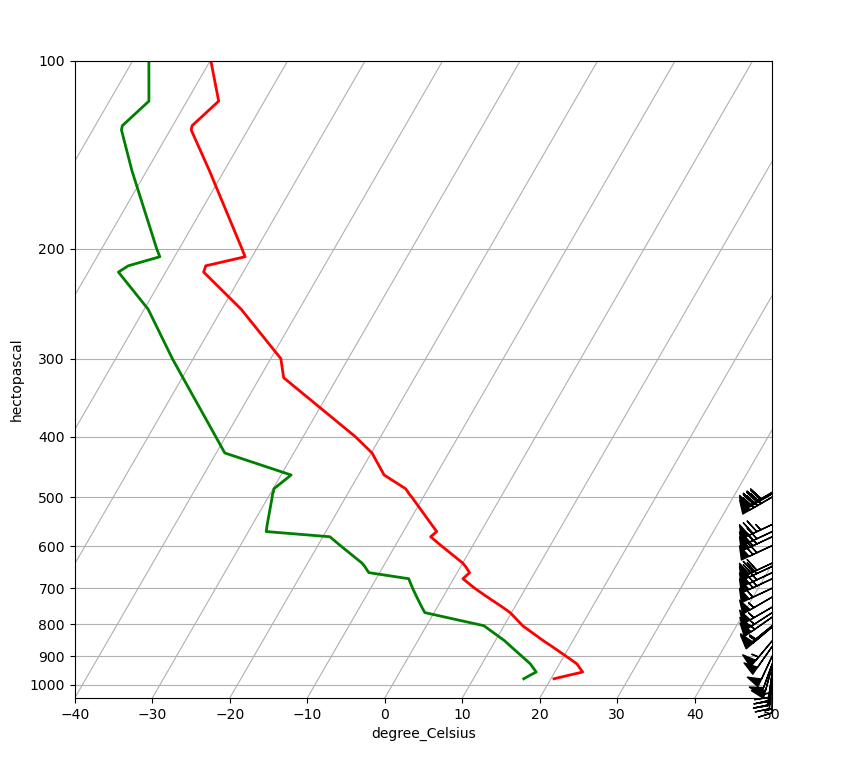

In [7]:
##########################################################################
# Thermodynamic Calculations
# --------------------------
#
# Often times we will want to calculate some thermodynamic parameters of a
# sounding. The MetPy calc module has many such calculations already implemented!
#
# * **Lifting Condensation Level (LCL)** - The level at which an air parcel's
#   relative humidity becomes 100% when lifted along a dry adiabatic path.
# * **Parcel Path** - Path followed by a hypothetical parcel of air, beginning
#   at the surface temperature/pressure and rising dry adiabatically until
#   reaching the LCL, then rising moist adiabatially.

# Calculate the LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])

print(lcl_pressure, lcl_temperature)

# Calculate the parcel profile.
parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')

##########################################################################
# Basic Skew-T Plotting
# ---------------------
#
# The Skew-T (log-P) diagram is the standard way to view rawinsonde data. The
# y-axis is height in pressure coordinates and the x-axis is temperature. The
# y coordinates are plotted on a logarithmic scale and the x coordinate system
# is skewed. An explanation of skew-T interpretation is beyond the scope of this
# tutorial, but here we will plot one that can be used for analysis or
# publication.
#
# The most basic skew-T can be plotted with only five lines of Python.
# These lines perform the following tasks:
#
# 1. Create a ``Figure`` object and set the size of the figure.
#
# 2. Create a ``SkewT`` object
#
# 3. Plot the pressure and temperature (note that the pressure,
#    the independent variable, is first even though it is plotted on the y-axis).
#
# 4. Plot the pressure and dewpoint temperature.
#
# 5. Plot the wind barbs at the appropriate pressure using the u and v wind
#    components.

# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r', linewidth=2)
skew.plot(p, Td, 'g', linewidth=2)
skew.plot_barbs(p, u, v)

# Show the plot
plt.show()

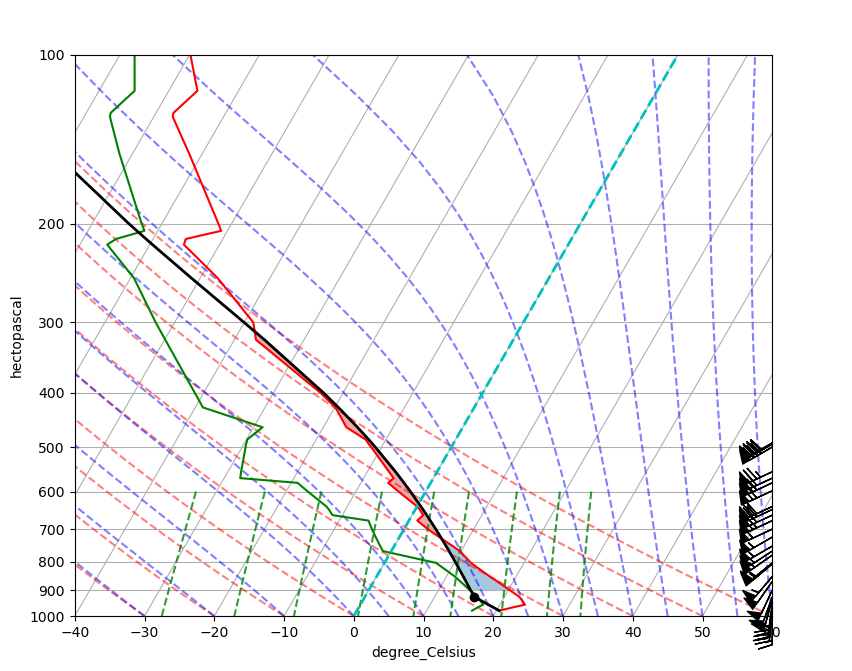

In [9]:
##########################################################################
# Advanced Skew-T Plotting
# ------------------------
#
# Fiducial lines indicating dry adiabats, moist adiabats, and mixing ratio are
# useful when performing further analysis on the Skew-T diagram. Often the
# 0C isotherm is emphasized and areas of CAPE and CIN are shaded.

# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Plot LCL temperature as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, parcel_prof, Td)
skew.shade_cape(p, T, parcel_prof)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Show the plot
plt.show()


AttributeError: LineCollection.set() got an unexpected keyword argument 'p'

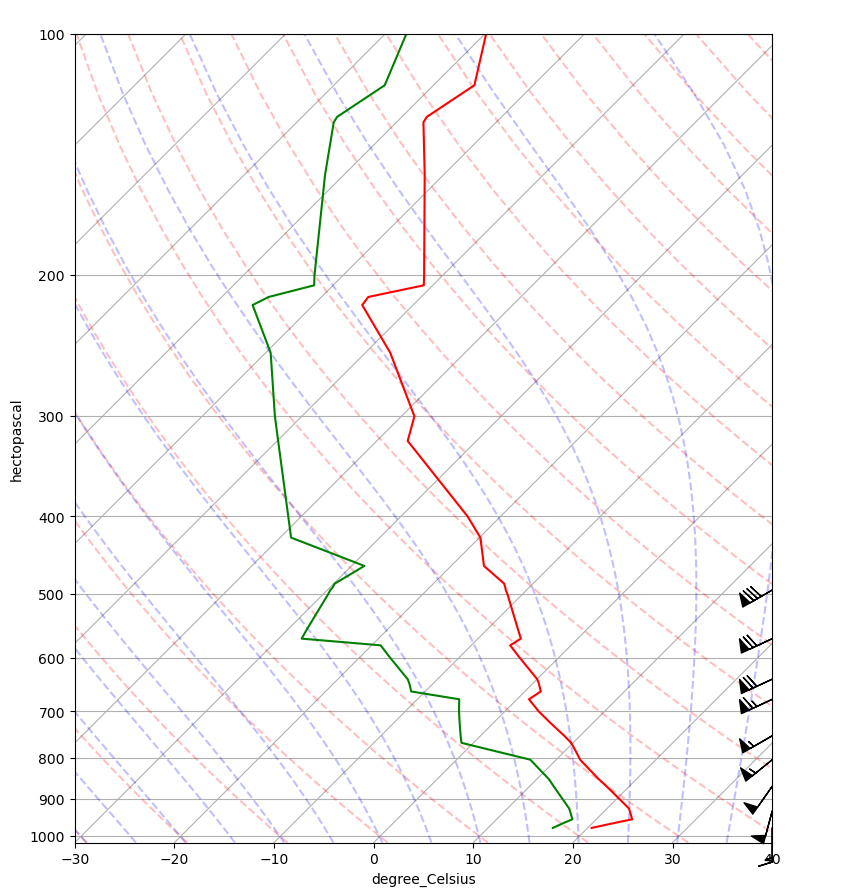

In [8]:
# Change default to be better for skew-T
fig = plt.figure(figsize=(9, 11))

# Initiate the skew-T plot type from MetPy class loaded earlier
skew = SkewT(fig, rotation=45)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p[::3], u[::3], v[::3], y_clip_radius=0.03)

# Set some appropriate axes limits for x and y
skew.ax.set_xlim(-30, 40)
skew.ax.set_ylim(1020, 100)

# Add the relevant special lines to plot throughout the figure
skew.plot_dry_adiabats(t0=np.arange(233, 533, 10) * units.K,
                       alpha=0.25, color='orangered')
skew.plot_moist_adiabats(t0=np.arange(233, 400, 5) * units.K,
                         alpha=0.25, color='tab:green')
skew.plot_mixing_lines(p=np.arange(1000, 99, -20) * units.hPa,
                       linestyle='dotted', color='tab:blue')

# Add some descriptive titles
plt.title('{} Sounding'.format(station), loc='left')
plt.title('Valid Time: {}'.format(dt), loc='right');

In [25]:
output = []

output.append(_get_pyversions())
output.append(_get_sysinfo())
output.append(_get_conda_env())


def _get_pyversions():
    return {
        "Python implementation": platform.python_implementation(),
        "Python version": platform.python_version(),
        "IPython version": IPython.__version__,
    }


def _get_sysinfo():
    return {
        "Compiler": platform.python_compiler(),
        "OS": platform.system(),
        "Release": platform.release(),
        "Machine": platform.machine(),
        "Processor": platform.processor(),
        "CPU cores": cpu_count(),
        "Architecture": platform.architecture()[0],
    }

def _get_conda_env():
    name = os.getenv('CONDA_DEFAULT_ENV', 'n/a')
    return {"conda environment": name}



NameError: name '_get_pyversions' is not defined